In [1]:
import pandas as pd
import numpy as np 
from flair.models import TextClassifier
from flair.data import Sentence
import umap
import sister
import hdbscan
import nltk
from nltk import word_tokenize 
from nltk.util import ngrams
import re 
from wordcloud import WordCloud, STOPWORDS
from textwrap import wrap
from sklearn import preprocessing
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from bertopic import BERTopic
#plotting library for interactive plots
import plotly
import plotly_express as px
pd.set_option('display.max_rows', None)
import os

In [2]:
#This function performs several preprocessing steps
def process_text(row):

    '''
    This function preprocesses text in a number of ways, removing special characters, etc.

    args: row = the row of text in a dataframe that you want to preprocess
    '''


    #lower case text 
    row = row.lower() 
    
    #remove apostrophe
    row = str.replace(row, "'", "")

    #remove unicode strings like "x96" 
    #row = re.sub(r'(\\u[0-9A-Fa-f]+)', "r", row) 
    #row = re.sub(r'[^\x00-\x7f]', "r", row)

    #convert any url to URL 
    row = re.sub('((www\.[^\s]+)|(https?://]^\s]+))', 'URL', row)

    #convert any @Username to 'AT_USER'
    row = re.sub('@[^\s]+', 'AT_USER', row)

    #Remove additional white space 
    row = re.sub('[\s]+', ' ', row)
    row = re.sub('[\n]+', ' ', row)

    #Remove non-alphanumeric symbols white spaces
    row = re.sub(r'[^\w]', ' ', row)

    #remove hashtag in front of a word 
    row = re.sub(r'#([^\s]+)', r'\1', row)

    #replace #word with word
    row = re.sub(r'#([^\s]+])', r'\1', row)

    #remove :( or :)
    row = row.replace(':)', '')
    row = row.replace(':(', '')

    #remove numbers
    row = ''.join([i for i in row if not i.isdigit()])

    #remove multiple exclamation 
    row = re.sub(r"(\!)\1+", ' ', row)

    #remove multiple question marks
    row = re.sub(r"(\?)\1+", ' ', row)

    #remove multistop 
    row = re.sub(r"(\.)\1+", ' ', row)

    #lemmatize 
    #row = "  ".join([Word(word).lemmatize() for word in row.split()])

    #stem 
    #stemmer = PorterStemmer()

    #row = " ".join([stemmer.stem(word) for word in row.split()])
    
    #remove emoticons from text
    row = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:\S|T\.T|\.\_\|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:X\-\(|>\.<|>=\(|D:', '', row)

    #trim 
    row = row.strip('\'"')

    return row 

In [3]:
#for removing stopwords and processing the text with our other text preprocessing functoin
def parse_text(df, col_to_parse):

    '''
    This function takes a column of text that you want to preprocess and parse and removes stopwords in addition to processing the 
    text with the function created above

    args: df = the dataframe you have with text, col_to_parse = the column in the df that is text
    '''
    
    #instantiate stop words list and append new terms to the list
    stop = [x for x in STOPWORDS]
    stop.append('customer')
    stop.append('Customer')
    stop.append('custom')
    stop.append('user')
    stop.append('User')
    stop.append('cx')
    stop.append('Cx')
    stop.append('The')
    stop.append('status')
    stop.append('summary')
    stop.append('https')
    stop.append('microsoft')
    stop.append('com')
    stop.append('www')
    stop.append('docs')
    #some customers were only entering 'hi' into the bot, so I added these in
    stop.append('Hi')
    stop.append('hi')
    #added in the word 'toronto' since this is just the name of the bot
    stop.append('Toronto')
    stop.append('toronto')
    #we are seeing some notes that are only x's
    stop.append('xxx')
    stop.append('xxxx')
    # stop.append('deployment')
    # stop.append('concerns')

    #remove some stopwords from the list
    stop = [e for e in stop if e not in 
        ('have', 'having', 'does', 'not', 'doesn', 'doesnt', 'dont', 'haven', 'havent', 'how', 
        'hasnt')]

    #process raw text
    df['processed_note'] = df[col_to_parse].apply(lambda x: process_text(x))\
            .apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    #remove stopwords
    df['processed_note'] = df['processed_note'].apply(lambda x: ' '.\
                join([word for word in x.split() if word not in (stop)]))
    
    return df

In [4]:
#function for running sentiment analysis on a column of text
def run_sentiment_analysis(df, text_to_classify, chunksize = 10):

    '''
    This function uses flair to run sentiment analysis on a column in your dataset, it creates a df with sentiment and 
    probability scores as two separate columns

    args: df = the df that you have, text_to_classify = the text column you want to run sentiment analysis on, 
    chunksize = the number of chunks you want to break your dataset into to speed up sentiment analysis
    '''

    #create list to store sentiment predictions
    preds = []
    
    #instantiate the sentiment model 
    classifier = TextClassifier.load('en-sentiment')

    #chunk out data to run sentiment analysis faster
    for chunk in np.array_split(df[text_to_classify], chunksize):
    
        #predict sentiment and store in our list
        for note in chunk:
    
            note = Sentence(note)
    
            classifier.predict(note)
    
            preds.append(note.labels)
        
    #create column for sentiment
    df['sentiment'] = [x for x in preds]

    #convert sentiment to string
    df['sentiment'] = df['sentiment'].astype(str)

    #remove brackets from label prediction
    df['sentiment'] = df['sentiment'].str.replace('[', '')

    df['sentiment'] = df['sentiment'].str.replace(']', '')

    #create two columns from our sentiment prediction, 1) sentiment 2) probability score
    df[['sentiment', 'prob']] = df['sentiment'].str.split(' ', 1, expand=True)

    #replace perentheses in probability scores
    df['prob'] = df['prob'].str.replace('(', '')
    
    df['prob'] = df['prob'].str.replace(')', '')

    #convert probabilities to floats
    df['prob'] = df['prob'].astype(float)
        
    #return the df
    return df


In [108]:
def vectorize_and_cluster(df, col_to_vectorize, max_k, model = 'kmeans', method = 'tfidf'):

    '''
    This function uses TF-IDF to vectorize a column of text and then clusters the data using either a K-Means or HDBSCAN model

    args: df = your df, col_to_vectorize = the column of text (preprocessed using the above functions) that you want to vectorize,
    model = the type of model you want to use for clustering (HDBSCAN or KMeans)
    method can be either 'sister' or 'tfidf'
    '''
    if method == 'tfidf':
        #instantiate the TF-IDF model and vectorize the notes
        vectorizer = TfidfVectorizer()
        vectorized_notes = vectorizer.fit_transform(df['processed_note'])
        
    #use sister for BERT embeddings
    elif method == 'sister':
        
        #create embeddings using BERT
        import sister
        sentence_embedding = sister.MeanEmbedding(lang="en")
        vectorized_notes = [sentence_embedding(sentence) for sentence in df[col_to_vectorize]]

    if model == 'kmeans':
        #determine how many clusters we should be using, looping through clusters up to max_k
        iters = range(2, 20+1, 2)
    
        #create list for inertia scores
        sse = []
    
        #loop through max_k and append inertia scores to list
        for k in iters:
            sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, 
            batch_size=2048, random_state=20).fit(vectorized_notes).inertia_)

        #create df from inertia scores and clusters
        inertia_df = pd.DataFrame(zip(iters, sse))

        #determine how many clusters we should be using based on intertia differences (elbow method)
        inertia_diffs = pd.DataFrame([i-j for i, j in zip(inertia_df.iloc[:-1, 1], 
                            inertia_df.iloc[1:, 1])])

        #take the smallest difference between intertia scores and use that as our cluster count
        cluster_index = inertia_diffs[inertia_diffs[0] == inertia_diffs[0].min()].index[0]

        optimal_cluster_num = inertia_df[inertia_df.index == cluster_index].iloc[0, 0]

        #instantiate K-Means 
        clusters = MiniBatchKMeans(n_clusters=optimal_cluster_num, init_size=1024, 
            batch_size=2048, random_state=20).fit_predict(vectorized_notes)

    elif model == 'hdbscan':

        clusters = hdbscan.HDBSCAN(min_cluster_size=300, min_samples = 1, 
                                    cluster_selection_method = 'leaf').fit_predict(vectorized_notes)

    #reduce vectors for visualization purposes using UMAP
#     import pyspark
#     import pynndescent
#     pynndescent.rp_trees.FlatTree.__module__  = "pynndescent.rp_trees"

    #instantiate the UMAP model and reduce vectors 
    reducer = umap.UMAP(n_neighbors=30, n_components = 3, min_dist = 0)
    reduced_vectors = reducer.fit_transform(vectorized_notes)

    #create df for reduced vectors and include the cluster number, note, processed note
    reduced_vectors_df = pd.DataFrame(reduced_vectors)

    reduced_vectors_df['cluster'] = clusters

    #reset the index since the note id is the index
    df.reset_index(drop = True, inplace = True)

    reduced_vectors_df.insert(loc = 4, column = 'note', value = df['note'])

    reduced_vectors_df.insert(loc = 5, column = 'processed_note', value = df['processed_note'])

    reduced_vectors_df.insert(loc = 6, column = 'date_entered', value = df['userentereddate'])

    reduced_vectors_df.rename(columns = {0:'dim1', 1:'dim2', 2:'dim3'}, inplace = True)

    #return the df
    return reduced_vectors_df

In [6]:
#find most common n_grams in clusters
def find_ngrams(text_col, ngram_range = (2, 3), top_ngrams = 10):


    '''
    This function takes a text column and finds the top n ngrams from that text

    args: text_col = the column of text in your df (in the form of df[text_col]), ngram_range = the ngrams you want to extract
    you can increase or decrease it as you wish, top_ngrams = the number of top ngrams you would like to extract
    '''    

    from sklearn.feature_extraction.text import CountVectorizer

    c_vec = CountVectorizer(ngram_range=ngram_range)
    
    # matrix of ngrams
    ngrams = c_vec.fit_transform(text_col)
    
    # count frequency of ngrams
    count_values = ngrams.toarray().sum(axis=0)
    
    # list of ngrams
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'ngram'})
    
    df_ngram = df_ngram.nlargest(top_ngrams, columns = 'frequency')

    return df_ngram

In [51]:

def find_topics(df, cluster_col, text_col, ngram_range = (3, 4), top_ngrams = 10):

    '''
    This function takes ngrams from topic clusters and creates a df that holds the cluster number and the top 10 ngrams for that cluster,
    the point of this is to merge this into the final df with all the notes we have

    args: df = a dataframe that holds text, this will be the negative reviews df that we create
    '''

    #create a list to store the sliced cluster dfs (each one is a subset of one cluster)
    clusters_dfs = []

    #loop through clusters and generate individual dfs for each cluster
    for cluster in df[cluster_col].unique():
    
        cluster_df = df[df[cluster_col] == cluster]
    
        #append to our list
        clusters_dfs.append(cluster_df)

    #create empty list to store the ngrams that we find using our function find_ngrams
    ngram_dfs = []

    unique_clusters = df[cluster_col].unique()

    #loop through cluster dfs in our first list and the number of clusters in the df
    for df, cluster in zip(clusters_dfs, unique_clusters):
    
        #find ngrams for each cluster
        ngram_df = find_ngrams(text_col = df[text_col], ngram_range = ngram_range, top_ngrams = top_ngrams)

        ngram_df['cluster'] = cluster
    
        #append to our list
        ngram_dfs.append(ngram_df)

    #just sets the option to see all text
    pd.set_option('display.max_colwidth', -1)

    #concatenate our dfs that have ngrams
    cluster_ngrams = pd.concat(ngram_dfs)

    #create list for our ngrams
    ngrams = []

    #loop through clusters 
    for cluster in cluster_ngrams.cluster.unique():

        #append out ngram column to the list
        ngrams.append([x for x in cluster_ngrams[cluster_ngrams['cluster'] == cluster]['ngram']])

    #create fd with clusters and their top ngrams
    topic_df = pd.DataFrame(zip(cluster_ngrams.cluster.unique(), ngrams))

    #rename our columns
    topic_df.rename(columns = {0:'cluster', 1:'topics'}, inplace = True)

    #remove brackets
    topic_df['topics'] = topic_df.topics.astype(str).str.replace('[', '')
    topic_df['topics'] = topic_df.topics.astype(str).str.replace(']', '')

    #return our new df
    return topic_df

In [8]:
#function for 3-d scatterplot for cluster visualization
def plot_clusters(df):

    #https://anaconda.org/conda-forge/jupyterlab-plotly-extension
    #gotta do this in jupyter notebook not lab for it to render, its a nightmare to figure it out in the lab

    plotly.offline.init_notebook_mode(connected=True)
    fig = px.scatter_3d(df, x='dim1', y='dim2', z='dim3', color='str_cluster', width = 800, 
        height = 800, hover_data = ['note'])
    fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
    fig.update_layout(
    title={
        'text': "Clustering Notes for Theme Analysis",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
    fig.show()

In [9]:
pwd

'C:\\Users\\v-sacannon\\Desktop\\FastTrack\\DTB\\Notebooks\\Churned Customer Analysis'

# Churned FastTrack Customers Botnote Analysis
- Looking at customers who have churned and what their notes are telling us
- Topic modeling all botnotes from before a customer churned

In [10]:
os.chdir('C:\\Users\\v-sacannon\\Desktop\\FastTrack\\DTB\\Data')

In [11]:
df = pd.read_csv('churned_customer_botnotes.csv')
df.columns = [c.lower() for c in df.columns]
df.head()

,tenantmasterdimid,tenantname,date_entered,note
0,201,WINBRO GROUP TECHNOLOGIES LLC,7/2/2018,Get toronto followup question
1,201,WINBRO GROUP TECHNOLOGIES LLC,7/2/2018,Ticket #:10646856 is closed without any resolu...
2,201,WINBRO GROUP TECHNOLOGIES LLC,7/2/2018,Ticket #:10646856 is closed without any resolu...
3,201,WINBRO GROUP TECHNOLOGIES LLC,7/2/2018,Ticket #10646856
4,201,WINBRO GROUP TECHNOLOGIES LLC,7/2/2018,Ticket #10646856 is closed without any resolut...


In [12]:
df.tenantmasterdimid.nunique()

820

In [13]:
df['note'] = df['note'].astype(str)
#run sentiment analysis 
df = run_sentiment_analysis(df, 'note')

2022-01-13 11:18:51,451 loading file C:\Users\v-sacannon\.flair\models\sentiment-en-mix-distillbert_4.pt


In [14]:
df.head()

,tenantmasterdimid,tenantname,date_entered,note,sentiment,prob
0,201,WINBRO GROUP TECHNOLOGIES LLC,7/2/2018,Get toronto followup question,NEGATIVE,0.9891
1,201,WINBRO GROUP TECHNOLOGIES LLC,7/2/2018,Ticket #:10646856 is closed without any resolu...,NEGATIVE,0.9998
2,201,WINBRO GROUP TECHNOLOGIES LLC,7/2/2018,Ticket #:10646856 is closed without any resolu...,NEGATIVE,0.9998
3,201,WINBRO GROUP TECHNOLOGIES LLC,7/2/2018,Ticket #10646856,POSITIVE,0.9925
4,201,WINBRO GROUP TECHNOLOGIES LLC,7/2/2018,Ticket #10646856 is closed without any resolut...,NEGATIVE,0.9998


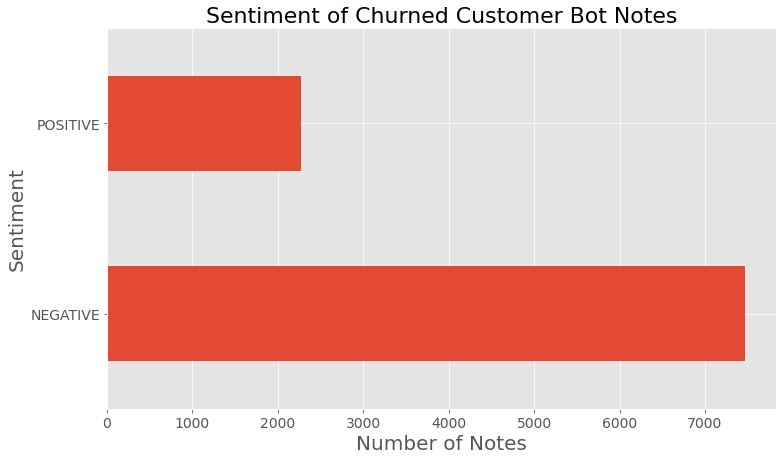

In [15]:
plt.style.use('ggplot')
df.sentiment.value_counts().plot(kind = 'barh', figsize = (12, 7))
plt.title('Sentiment of Churned Customer Bot Notes', fontsize = 22)
plt.xlabel('Number of Notes', fontsize = 20)
plt.ylabel('Sentiment', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14);

In [16]:
df = parse_text(df, 'note')

In [17]:
df.head()

,tenantmasterdimid,tenantname,date_entered,note,sentiment,prob,processed_note
0,201,WINBRO GROUP TECHNOLOGIES LLC,7/2/2018,Get toronto followup question,NEGATIVE,0.9891,followup question
1,201,WINBRO GROUP TECHNOLOGIES LLC,7/2/2018,Ticket #:10646856 is closed without any resolu...,NEGATIVE,0.9998,ticket closed without resolution please provid...
2,201,WINBRO GROUP TECHNOLOGIES LLC,7/2/2018,Ticket #:10646856 is closed without any resolu...,NEGATIVE,0.9998,ticket closed without resolution please re ope...
3,201,WINBRO GROUP TECHNOLOGIES LLC,7/2/2018,Ticket #10646856,POSITIVE,0.9925,ticket
4,201,WINBRO GROUP TECHNOLOGIES LLC,7/2/2018,Ticket #10646856 is closed without any resolut...,NEGATIVE,0.9998,ticket closed without resolution


In [115]:
#remove rows that are only one word now
wantedRows = df[df['processed_note'].str.split().str.len()==1].index 
df2 = df.drop(wantedRows, axis = 0)

In [116]:
#remove notes that only contain stopwords, these notes cannot run through the function
#empty strings
df2['processed_note'].replace('', np.nan, inplace=True)
df2.dropna(subset = ['processed_note'], inplace = True)

In [117]:
#gotta rename the date column to use this function
df2.rename(columns = {'date_entered':'userentereddate'}, inplace = True)
clusters = vectorize_and_cluster(df2, 'processed_note', max_k = 20, model = 'kmeans', method = 'sister')

Loading model...


In [118]:
#find topic ngrams and create column - this was throwing an error when looking for bigrams and above
# the issue here is that we have a lot of notes that are only single words
cluster_topics = find_topics(clusters, 'cluster', 'processed_note', ngram_range = (2, 3), top_ngrams = 5)

In [119]:
clusters = clusters.merge(cluster_topics)

In [120]:
cluster_topics

,cluster,topics
0,0,'followup question'
1,6,"'service request', 'create service request', 'create service', 'delete tenant', 'please call'"
2,12,"'credit card', 'payment method', 'exchange online', 'us call', 'let us call'"
3,9,"'azure ad', 'not working', 'need help', 'skype business', 'does not'"
4,11,"'receiving emails', 'need help', 'email address', 'email account', 'send email'"
5,8,"'outlook web', 'mobile device', 'skype business', 'mobile devices', 'smtp relay'"
6,10,"'cancel office', 'office subscription', 'cancel office subscription', 'install office', 'office proplus'"
7,5,"'email address', 'email account', 'forward email', 'add email', 'set email'"
8,14,"'close account', 'office account', 'close office account', 'close office', 'restore deleted account'"
9,2,"'search solutions', 'search setup', 'search function'"


Text(0.5, 1.0, 'Botnote Topics for Churned FT Customers')

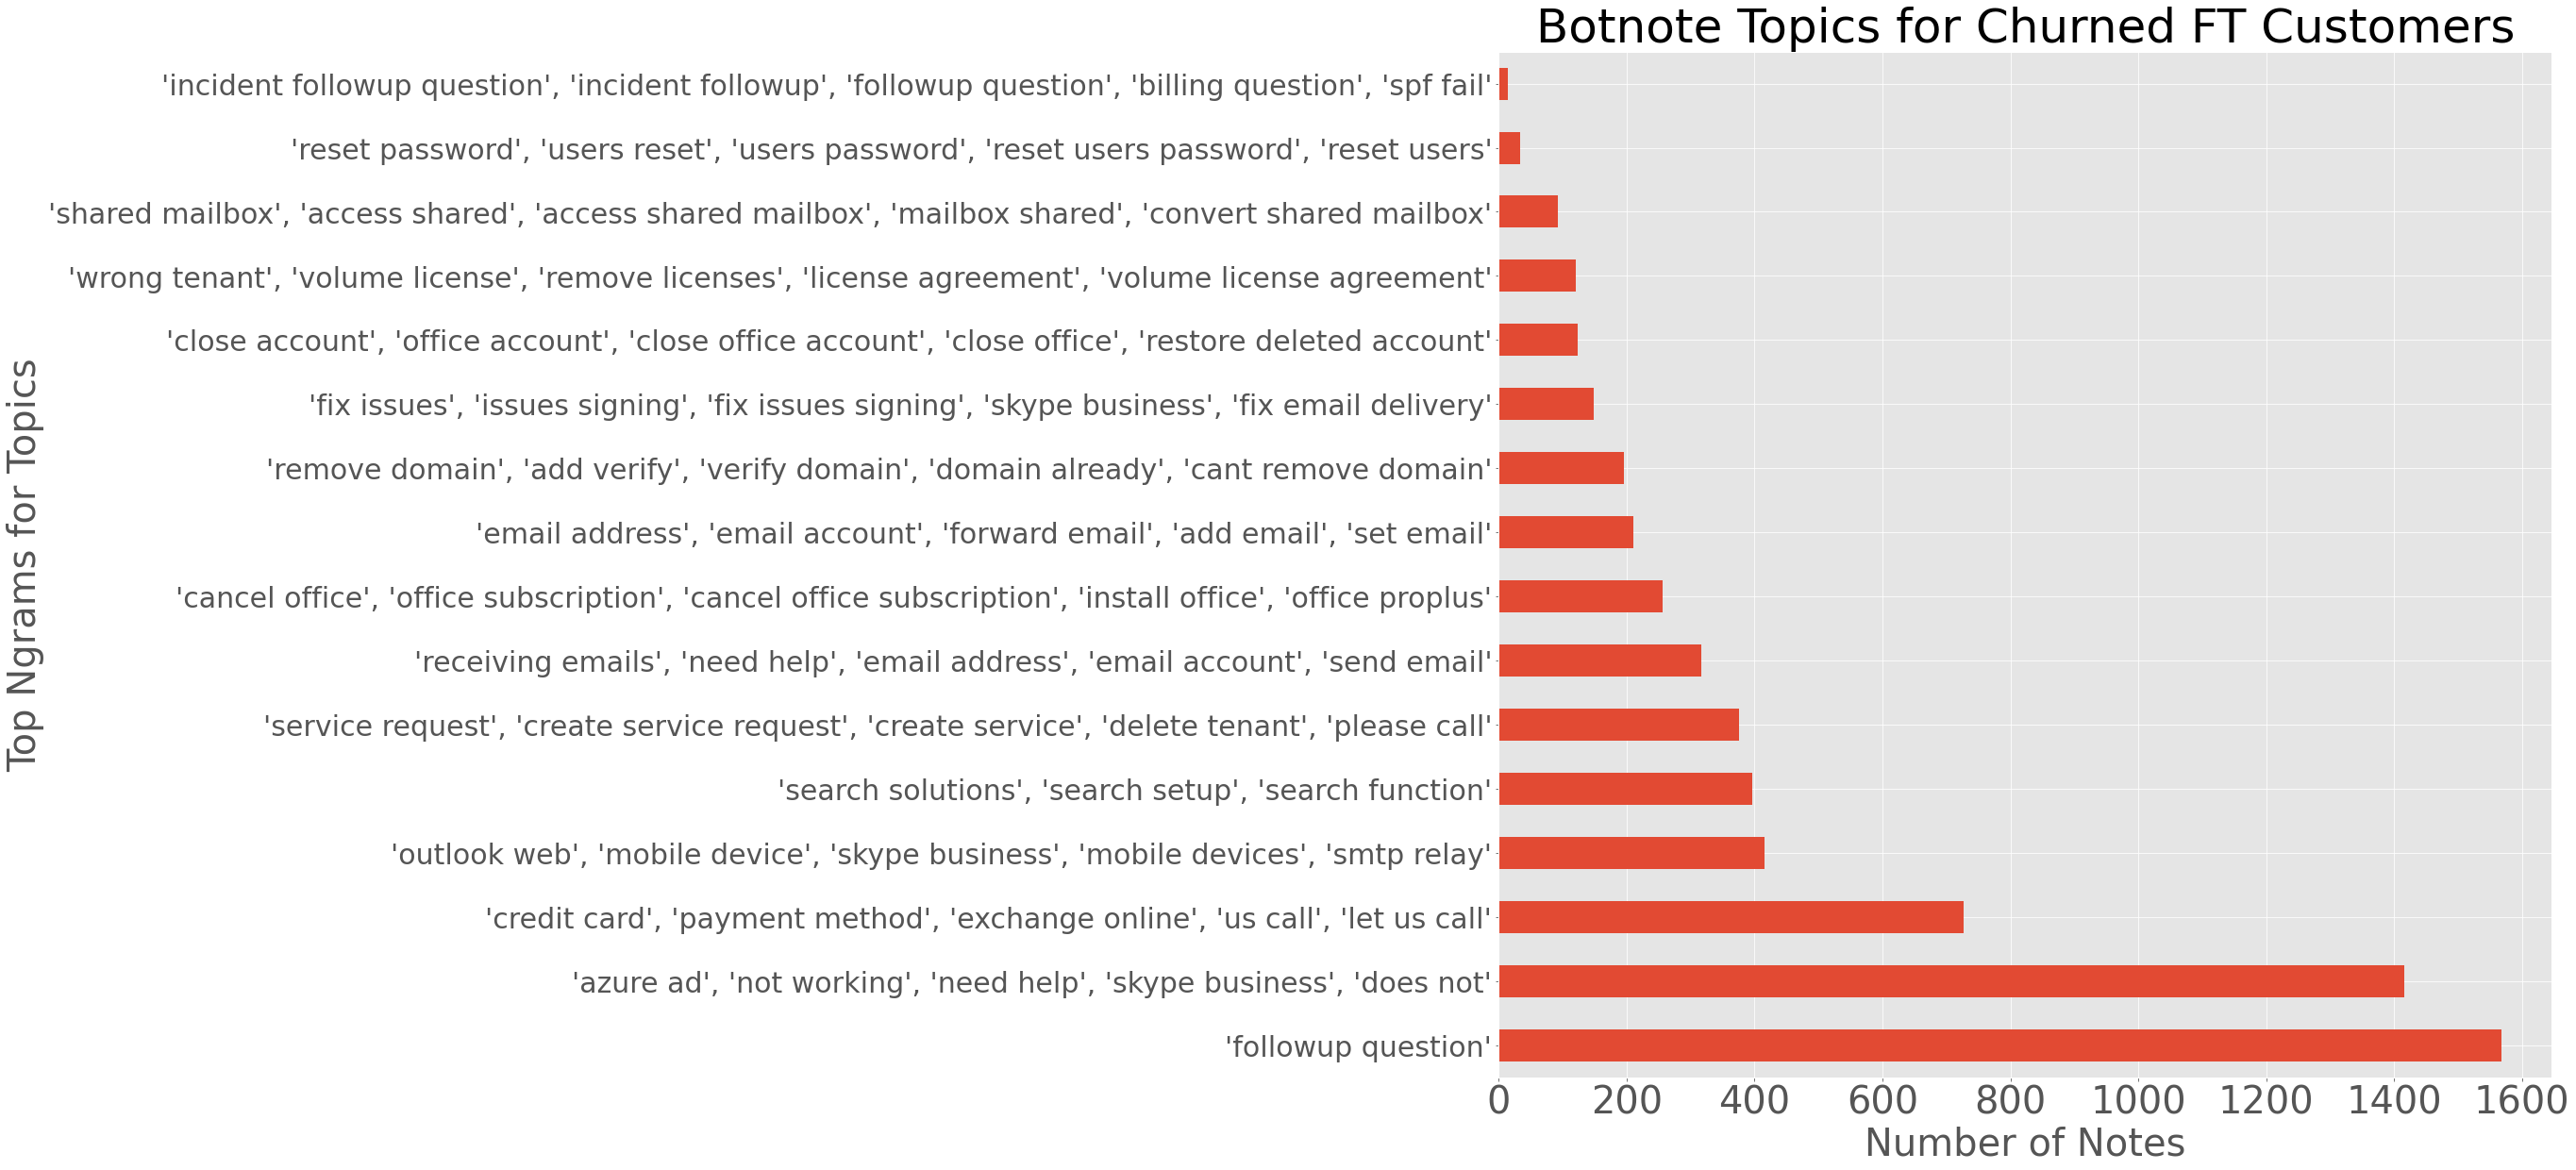

In [123]:
ax = clusters.topics.value_counts().plot(kind = 'barh', figsize = (20, 20))
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 40)
plt.xlabel('Number of Notes', fontsize = 40)
plt.ylabel('Top Ngrams for Topics', fontsize = 40)
plt.title('Botnote Topics for Churned FT Customers', fontsize = 50)